<a href="https://colab.research.google.com/github/paulf35/winequality/blob/main/CD_Proj2_SpanishWines_Modeling_withFE_V2_CORE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict the quality of Spanish wines based on existing data
Data Source: https://www.kaggle.com/datasets/fedesoriano/spanish-wine-quality-dataset



# Add imports and functions

## Imports

In [347]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, \
precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, \
classification_report
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

## Functions

In [348]:
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

# Load data and mount Google Drive

In [349]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [350]:
# Load data in from Google Drive
fname = "/content/drive/MyDrive/CodingDojo/02-MachineLearning/Week07/Data/wines_SPA.csv"
df = pd.read_csv(fname)

# Load first 5 rows
df.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


# Data Exploration

In [351]:
# Check types
df.dtypes

winery          object
wine            object
year            object
rating         float64
num_reviews      int64
country         object
region          object
price          float64
type            object
body           float64
acidity        float64
dtype: object

In [352]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       7500 non-null   object 
 1   wine         7500 non-null   object 
 2   year         7498 non-null   object 
 3   rating       7500 non-null   float64
 4   num_reviews  7500 non-null   int64  
 5   country      7500 non-null   object 
 6   region       7500 non-null   object 
 7   price        7500 non-null   float64
 8   type         6955 non-null   object 
 9   body         6331 non-null   float64
 10  acidity      6331 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 644.7+ KB


There are missing vlaues for type, body, acidity, and year. We'll need to impute those before building the models.

In [353]:
# Shape
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns.')

There are 7500 rows and 11 columns.


In [354]:
# Describe
df.describe(exclude='number')

,winery,wine,year,country,region,type
count,7500,7500,7498,7500,7500,6955
unique,480,847,71,1,76,21
top,Contino,Reserva,2011,Espana,Rioja,Rioja Red
freq,457,467,1190,7500,2440,2357


Notes:
- No major outliers, but winery and wine are very high cardinality.

In [355]:
df.describe(include='number')

,rating,num_reviews,price,body,acidity
count,7500.000000,7500.000000,7500.000000,6331.000000,6331.000000
mean,4.254933,451.109067,60.095822,4.158427,2.946612
std,0.118029,723.001856,150.356676,0.583352,0.248202
min,4.200000,25.000000,4.990000,2.000000,1.000000
25%,4.200000,389.000000,18.900000,4.000000,3.000000
50%,4.200000,404.000000,28.530000,4.000000,3.000000
75%,4.200000,415.000000,51.350000,5.000000,3.000000
max,4.900000,32624.000000,3119.080000,5.000000,3.000000


In [356]:
# Check object columns for inconsistent data

# Create a series of the datatypes
d_types = df.dtypes
# Create a filter to select only the object datatypes
object_d_types = d_types[(d_types == "object")]
# Display the series of object datatypes
object_d_types

# display unique values from each column
for column in object_d_types.index:
  print(column)
  print(df[column].unique())
  print('\n')

winery
['Teso La Monja' 'Artadi' 'Vega Sicilia' 'Pago de Carraovejas'
 'Toro Albala' 'Bodegas El Nido' 'Valdespino' 'Dominio de Pingus'
 'Alvaro Palacios' 'Ordonez' 'Bodegas Valduero' 'Vina Sastre'
 'Sierra Cantabria' 'Descendientes de J. Palacios' 'La Rioja Alta'
 'Marques de Murrieta' 'Vinedos de Paganos' 'Emilio Moro'
 'Quinta de la Quietud' 'Bodegas Mauro' 'Bodega Contador (Benjamin Romeo)'
 'Remirez de Ganuza' 'Bodegas San Roman' 'Pago de Los Capellanes'
 'Bodega Numanthia' 'Alto Moncayo' 'Mas Doix' 'Finca Moncloa'
 'Bodegas Roda' 'Martinet' 'Recaredo' 'Clos Erasmus' 'Barbadillo'
 'Gonzalez-Byass' 'Bodegas Amaren' 'Alvear' 'Equipo Navazos' 'Morca'
 'Territorio Luthier' 'Rafael Palacios' 'Terra Remota'
 'Dehesa de Los Canonigos' 'Miguel Merino' 'Gutierrez de la Vega' 'Alion'
 'Aalto' 'Carmelo Rodero' 'Dominio del Bendito' "Mas d'en Gil"
 'Casa Castillo' 'Matarromera' 'Nin-Ortiz' 'Vinas del Vero'
 'Marques de Riscal' 'Arzuaga' 'Bodegas Mas Alta' 'Dominio de Calogia'
 'Tomas Postigo'

In [357]:
# Check number columns for inconsistent data

# Create a series of the datatypes
d_types = df.dtypes
# Create a filter to select only the object datatypes
num_d_types = d_types[(d_types != "object")]
# Display the series of object datatypes
num_d_types

# display unique values from each column
for column in num_d_types.index:
  print(column)
  print(df[column].unique())
  print('\n')

rating
[4.9 4.8 4.7 4.6 4.5 4.4 4.3 4.2]


num_reviews
[   58    31  1793  1705  1309  1209  1201   926   643   630   591   454
   438   417   398   372   295   250   217   211   174   172   145   139
   125   118   103    87    84    79    70    69    68    56    52    50
    40    32    28    26 12421  5266  4350  3929  3437  3164  3127  2935
  2826  2765  2480  2419  2177  1892  1199  1141   940   935   690   685
   675   593   560   543   511   476   442   425   393   347   312   308
   303   300   292   291   285   280   268   264   256   254   251   243
   240   225   220   214   205   203   196   184   173   171   137   136
   134   133   132   131   127   123   117   116   112   110   108   102
   100    94    92    89    82    80    74    72    67    65    64    63
    60    59    57    53    51    49    47    45    42    41    39    37
    35    33    30    29    27  6803  5938  5545  5116  4747  4685  4516
  3383  3239  2416  2208  1608  1363  1108  1015   936   840   790   

In [358]:
# check year value_counts
df['year'].value_counts()

2011    1190
2016     897
2015     860
2018     850
2017     731
        ... 
1953       1
1972       1
1974       1
1931       1
1925       1
Name: year, Length: 71, dtype: int64

In [359]:
## Display the number of duplicate rows in the dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 5452 duplicate rows.


## Summary of Cleanup Needed
- Remove all duplicate rows
- Remove `winery`, `region`, and `wine` columns because of high cardinality in data.  
- Address `N.V.` value in Year feature
- Remove country because they are all labeled as `Espana'


# Data Cleanup

## Remove duplicate rows

In [360]:
# Remove duplicate rows
df = df.drop_duplicates()

## Confirm duplicate rows have been dropped
print(f'There are {df.duplicated().sum()} duplicate rows.')


There are 0 duplicate rows.


## Clean up inconsistent 'year' values

In [361]:
# Remove rows with missing columns
df.dropna(subset=['year'], inplace=True)

#Remove N.V. rows from year
df = df[df.year != 'N.V.']

#Convert to INT
df['year'] = df['year'].astype(int)

## Drop columns

In [362]:
# Remove unneeded columns
df.drop(columns=['country','winery', 'wine', 'region'], inplace=True)

## Verify changes

In [363]:
#Verify changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1976 entries, 0 to 6100
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         1976 non-null   int64  
 1   rating       1976 non-null   float64
 2   num_reviews  1976 non-null   int64  
 3   price        1976 non-null   float64
 4   type         1877 non-null   object 
 5   body         1714 non-null   float64
 6   acidity      1714 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 123.5+ KB


# Feature Engineering

Previous models to predict exact price were not accurate with original dataset. Instead of predicting the exact price, we'll instead predict if the wine is expensive or not. `is_expensive=1` means that the bottle of wine is greater than the average price of the entire data set.

In [364]:
# Encode cars with prices above the mean as 1 and below the mean as 0

df['is_expensive'] = df['price'].apply(lambda x: 1 if x > df['price'].mean() else 0)
df['is_expensive'].value_counts()

0    1570
1     406
Name: is_expensive, dtype: int64

# Preprocessing

## Split Data

In [365]:
# split X and y, we are predicting price
X = df.drop(columns=['price', 'is_expensive'])
y = df['price']

# split training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Bin the Target

In [366]:
df['price'].head()

0    995.00
1    313.50
2    324.95
3    692.96
4    778.06
Name: price, dtype: float64

In [367]:
mean_price = y_train.mean()

def bin_price(x):
    if x >= mean_price:
        return 1
    else:
        return 0

y_train = y_train.apply(bin_price)
y_test = y_test.apply(bin_price)

## Verify counts

In [368]:
y_train.value_counts()

0    1181
1     301
Name: price, dtype: int64

In [369]:
y_test.value_counts()

0    403
1     91
Name: price, dtype: int64

# Build the Base model

### Numeric Pipeline

In [370]:
# PREPROCESSING PIPELINE FOR NUMERIC DATA

# Save list of number column names
num_cols = X_train.select_dtypes('number').columns

# Transformers
scaler = StandardScaler()
med_imputer = SimpleImputer(strategy = 'median')

# Pipeline
num_pipeline = make_pipeline(med_imputer, scaler)
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

### Nominal Pipeline

In [371]:
# PREPROCESSING PIPELINE FOR ONE-HOT-ENCODED DATA

# Save list of nominal column names
nominal_cols = X_train.select_dtypes('object').columns

# Transformers

missing_imputer = SimpleImputer(strategy='constant', fill_value='missing')
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Pipeline
nom_pipeline = make_pipeline(missing_imputer, ohe)
nom_pipeline

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [372]:
# Nominal Tuple
ohe_tuple = ('categorical',nom_pipeline, nominal_cols)

### Create Column Transformer

In [373]:
# Instantiate the make column transformer
col_transformer = ColumnTransformer([numeric_tuple,
                                       ohe_tuple],
                                       remainder='drop', verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('number',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['year', 'rating', 'num_reviews', 'body', 'acidity'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['type'], dtype='object'))],
                  verbose_feature_names_out=False)

In [374]:
# Numeric Tuple
numeric_tuple = ('number',num_pipeline, num_cols)

In [375]:
# Instantiate Bagged Tree Regressor
lreg = LogisticRegression(max_iter=1000)

# Model Pipeline
lreg_pipe = make_pipeline(col_transformer, lreg)

# Fit the model pipeline on the training data only
lreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['year', 'rating', 'num_reviews', 'body', 'acidity'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

# Default Logistical Regression Model

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1181
           1       0.82      0.62      0.71       301

    accuracy                           0.90      1482
   macro avg       0.87      0.80      0.82      1482
weighted avg       0.89      0.90      0.89      1482



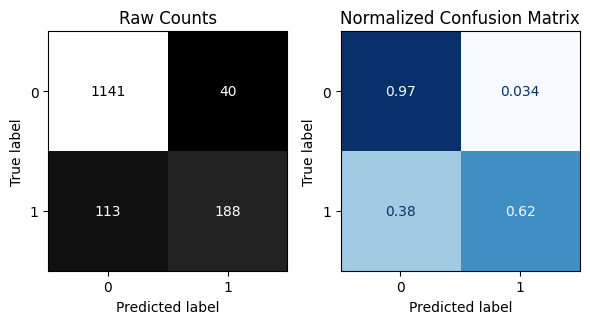


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       403
           1       0.76      0.57      0.65        91

    accuracy                           0.89       494
   macro avg       0.84      0.77      0.79       494
weighted avg       0.88      0.89      0.88       494



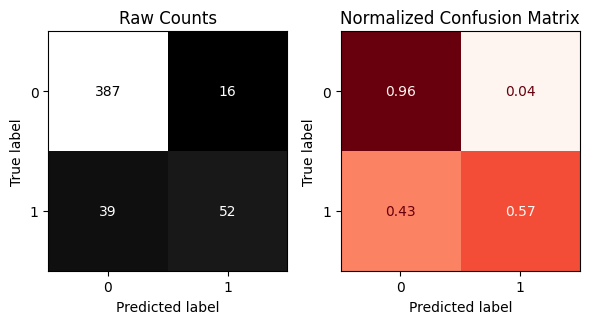

In [376]:
# Evaluate the default model
evaluate_classification(lreg_pipe, X_train, y_train, X_test, y_test)

# Test a Tuned Logistical Regression Model

In [378]:
# Define the param grid
params_lr={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'logisticregression__solver': ['liblinear'],
        'logisticregression__penalty': ['l1', 'l2'],
        'logisticregression__class_weight': ['balanced', None]
        }

# Create the GridSearchCV object with required args
gs = GridSearchCV(lreg_pipe, params_lr, verbose=True, n_jobs=-1,
                  return_train_score=True, scoring='recall_macro')
# Fit the gridsearch and display best params
gs.fit(X_train, y_train)
print(f'Best Params: {gs.best_params_}')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Params: {'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}


In [379]:
# Define the best version of the model
lr_best_model = gs.best_estimator_

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1181
           1       0.59      0.82      0.69       301

    accuracy                           0.85      1482
   macro avg       0.77      0.84      0.79      1482
weighted avg       0.88      0.85      0.86      1482



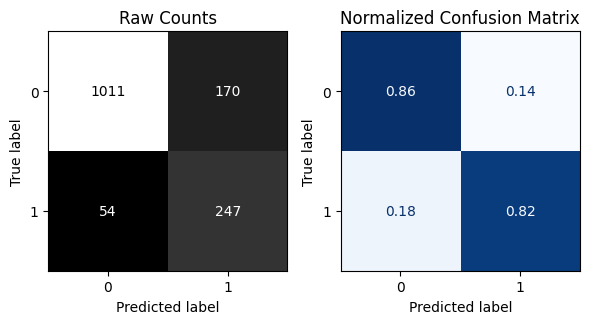


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       403
           1       0.53      0.85      0.66        91

    accuracy                           0.84       494
   macro avg       0.75      0.84      0.77       494
weighted avg       0.88      0.84      0.85       494



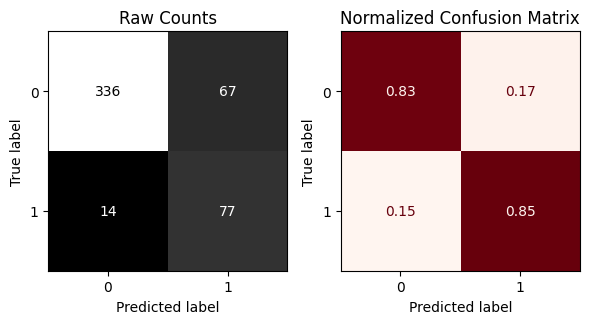

In [380]:
# Predict and Evaluate with custom function
evaluate_classification(lr_best_model, X_train, y_train, X_test, y_test)

# Findings:

The Tuned Logistical Regression (LR) model produced the best results. For this model, it's important that we have accureate True Positive and True Negative rates. The tuned LR model produced True Positives `85%` of the time and True Negatives `83%` of the time.

While the Default LR model produced more accurate True Negative preductions, its True Positive performance was significantly below the Tuned LR model's performance.

As a result of these evaluations, I recommend using the Tuned LR model for production.